# Multi-Label Classification

### The Data

In [52]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [53]:
df = pd.read_csv(path/'train.csv')
df.head(5)

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [68]:
valid = df[df.is_valid == True]
not_valid = df[df.is_valid == False]

In [69]:
tmp_df = pd.DataFrame({'a':[1,2], 'b':[3,4]})
tmp_df

,a,b
0,1,3
1,2,4


In [80]:
tmp_df['c'] = np.multiply(tmp_df.a, tmp_df.b)

In [81]:
tmp_df

,a,b,c
0,1,3,3
1,2,4,8


## constructing a DataBlock

In [83]:
dblock = DataBlock()
dsets = dblock.datasets(df)

In [86]:
len(dsets.train), len(dsets.valid)

(4009, 1002)

In [93]:
x, y = dsets.train[0]
x, y

(fname       005395.jpg
 labels           sheep
 is_valid          True
 Name: 2706, dtype: object,
 fname       005395.jpg
 labels           sheep
 is_valid          True
 Name: 2706, dtype: object)

In [94]:
def get_x(r): return r.fname
def get_y(r): return r.labels

dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)

dsets.train[0]

('000228.jpg', 'aeroplane')

In [96]:
def get_x(r): return path/'train'/r.fname
def get_y(r): return r.labels.split(' ')

dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/009059.jpg'), ['bus'])

TensorMultiCategory([0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])


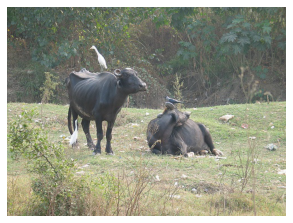

In [103]:
# we need to replace categoryblock with multicategoryblock

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                      get_x = get_x, get_y = get_y)

dsets = dblock.datasets(df)
x, y = dsets.train[0]
print(y)
x.show();

In [109]:
idxs = torch.where(dsets.train[0][1] == 1.)[0]
print(idxs)
dsets.train.vocab[idxs]

TensorMultiCategory([2, 9])


(#2) ['bird','cow']

In [139]:
def splitter(df):
    train = df.index[~df.is_valid].tolist()
    valid = df.index[df.is_valid].tolist()
    return train, valid

In [140]:
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                      splitter = splitter,
                      get_x = get_x,
                      get_y = get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [144]:
dblock = DataBlock(
            blocks = (ImageBlock, MultiCategoryBlock),
            splitter = splitter,
            get_x = get_x,
            get_y = get_y,
            item_tfms = Resize(500)
)

dls = dblock.dataloaders(df)

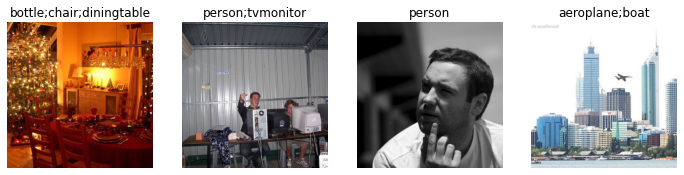

In [145]:
dls.train.show_batch(nrows = 1, ncols=4)

In [148]:
dblock.summary(df)

Setting-up type transforms pipelines
0     000005.jpg           chair      True
1     000007.jpg             car      True
2     000009.jpg    horse person      True
3     000012.jpg             car     False
4     000016.jpg         bicycle      True
...          ...             ...       ...
5006  009954.jpg    horse person      True
5007  009955.jpg            boat      True
5008  009958.jpg  person bicycle      True
5009  009959.jpg             car     False
5010  009961.jpg             dog     False

[5011 rows x 3 columns]
Found 5011 items
2 datasets of sizes 2501,2510
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}

Building one sample
  Pipeline: get_x -> PILBase.create
    starting from
      fname       000012.jpg
labels             car
is_valid         False
Name: 3, dtype: object
    applying get_x gives
      /root/.fastai/data/pascal_2007/train/00001

## Binary Cross-Entropy

In [149]:
learn = cnn_learner(dls, resnet18)

In [151]:
nn.Module?

In [157]:
x, y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [168]:
activs[0]

tensor([ 0.6598,  0.8316, -2.7336,  0.6845, -1.1628,  0.3575,  4.8175, -2.4783,
        -3.5301,  1.3224,  3.1141,  0.7915, -2.0779,  0.1104, -0.6835, -4.0940,
         0.7220, -4.4442,  2.8258,  4.2547], grad_fn=<SelectBackward>)

In [169]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, 1-inputs, inputs)

In [171]:
binary_cross_entropy(activs, y)[0]

TensorMultiCategory([-0.6592, -0.6967, -0.0610, -0.6647, -0.2382, -0.5884, -0.9920, -0.0774,
        -0.0285, -0.2104, -0.9575, -0.6882, -0.1113, -0.5276, -0.3355, -0.0164,
        -0.6730, -0.0116, -0.9441, -0.9860], grad_fn=<AliasBackward>)

In [173]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0672, grad_fn=<AliasBackward>)

In [179]:
def accuracy_multi(inp, targ, thresh=.5, sigmoid=True):
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [183]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=.2))

In [184]:
learn.fine_tune(3, base_lr=3e-3, freeze_epochs = 4)

epoch,train_loss,valid_loss,accuracy_multi,time


RuntimeError: CUDA out of memory. Tried to allocate 978.00 MiB (GPU 0; 7.94 GiB total capacity; 5.80 GiB already allocated; 700.50 MiB free; 6.72 GiB reserved in total by PyTorch)